In [2]:
import numpy as np
import pandas as pd

import syndat.dt_null_encoder as dt_null_encoder
import syndat.data_generator as sdg

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# create test df with continuous, categorical, and date/time vars
n = 10000
x_norm = np.random.randn(n)
x_unif = np.random.rand(n)
x_int = np.random.randint(0, 10, size=n)
x_categ = np.random.choice(['c1','c2','c3'], size=n, p=[0.2,0.3,0.5])
x_date = np.random.permutation(
    pd.date_range('2000-01-01', '2020-01-01', periods=n)
)

df = pd.DataFrame(
    {'x_norm':x_norm, 'x_unif':x_unif, 'x_int': x_int, 'x_categ':x_categ, 'x_date':x_date}
)

# convert dt to str to make the data more realistic
df['x_date'] = df['x_date'].apply(lambda x: x.strftime('%Y-%m-%d'))

df.head()

,x_norm,x_unif,x_int,x_categ,x_date
0,0.785733,0.763638,6,c3,2009-08-05
1,1.314424,0.812481,1,c2,2009-05-06
2,-0.165295,0.829847,4,c3,2009-11-26
3,0.202155,0.375992,7,c1,2009-01-31
4,0.152412,0.664950,7,c2,2016-12-09


In [4]:
# inject NAs
n_na = int(len(df)/100)
for c in df.columns:
    df.loc[np.random.choice(np.arange(len(df)), n_na), c] = np.nan
df.isnull().sum()

x_norm     100
x_unif     100
x_int      100
x_categ     99
x_date      99
dtype: int64

In [5]:
cols = {
    'x_norm':'float',
    'x_unif':'float',
    'x_int':'int',
    'x_categ':'unord',
    'x_date':'dt'
}

# Synthetic data generation

In [6]:
# dt na encoding
df_orig = df.copy() # need df_orig for decoding dt nulls
df = dt_null_encoder.encode(df, cols)

In [7]:
df.isnull().sum()

x_norm     100
x_unif     100
x_int      100
x_categ     99
x_date       0
dtype: int64

## Multivariate density estimation and sampling

In [8]:
# the multivariate approach cannot hadnle NAs in int and float columns.
# impute NAs before calling syndat
df_imp = df.copy()

# replace NAs with 0 for now - can do "better", e.g., replace with median
df_imp[['x_norm', 'x_unif', 'x_int']] = df_imp[['x_norm', 'x_unif', 'x_int']] .fillna(0)

df_imp.isnull().sum()

x_norm      0
x_unif      0
x_int       0
x_categ    99
x_date      0
dtype: int64

In [9]:
sd = sdg.DataGenerator(df_imp, cols, multivariate=True, convert_dt=True)

/home/aras/.venv/syndat/lib64/python3.10/site-packages/syndat/data_generator.py:49: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  self.df = data[cols].copy()


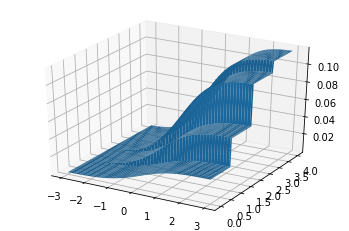

In [9]:
# plot mixture of continuous and categorical - CDF
x=np.linspace(-3,3,100)
y=np.linspace(0,4,100)
X, Y = np.meshgrid(x,y)
x_unif_samp = 0.5
x_int_samp = np.median(sd.df['x_int'])
x_date_samp = np.median(sd.df['x_date'])
z = np.array([sd.kde.cdf([x,x_unif_samp,x_int_samp,y,x_date_samp]) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = z.reshape(X.shape)

ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,Z)

Note that the fourth category corresponds to NAs

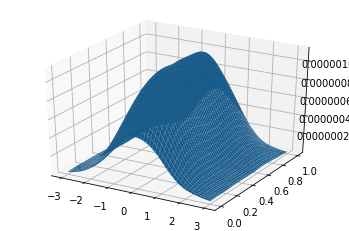

In [10]:
# plot continuous vars - PDF
x=np.linspace(-3,3,100)
y=np.linspace(0,1,100)
X, Y = np.meshgrid(x,y)
x_int_samp = np.median(sd.df['x_int'])
x_categ_samp = 2
x_date_samp = np.median(sd.df['x_date'])
z = np.array([sd.kde.pdf([x,y,x_int_samp,x_categ_samp,x_date_samp]) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = z.reshape(X.shape)

ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,Z)

In [51]:
# get synthetic data
df_samp = sd.get_sample(n=1000)

In [52]:
df_samp.head()

,x_norm,x_unif,x_int,x_categ,x_date
0,3.234246,0.733594,5,c3,2005-04-14
1,1.093019,0.020953,2,c3,1988-03-24
2,0.734054,0.553931,4,c2,2001-09-06
3,2.643801,0.792003,3,c3,2012-08-05
4,0.616160,0.045633,4,c3,2003-05-24


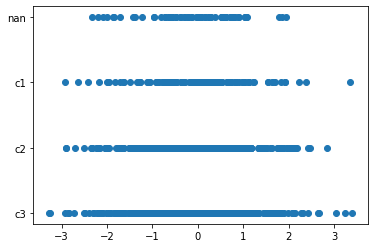

In [53]:
# plot sampled data - normal vs categorical
ax = plt.axes()
ax.scatter(df_samp['x_norm'],df_samp['x_categ'])

Note the addition of the nan category. If desired, NAs can be imputed before calling syndat

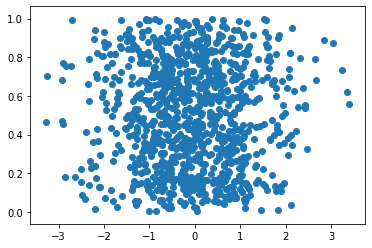

In [54]:
# plot sampled data - normal vs uniform
ax = plt.axes()
ax.scatter(df_samp['x_norm'],df_samp['x_unif'])

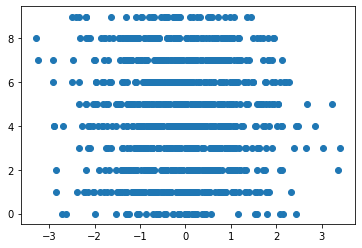

In [56]:
# plot sampled data - normal vs int uniform
ax = plt.axes()
ax.scatter(df_samp['x_norm'],df_samp['x_int'])

## Univariate density estimation and sampling

In [71]:
# unlike the multivariate approach, the univariate approach
# does not break if there are NAs in float cols
# the UV KDE can also handle NAs in int columns, but sampling
# breaks since int type does not support nan
df.isnull().sum()

x_norm     100
x_unif     100
x_int        0
x_categ     99
x_date       0
dtype: int64

In [72]:
df['x_int'] = df['x_int'].fillna(0)

In [73]:
sd = syndat.SynDat(df, cols, multivariate=False, convert_dt=True)

/Users/mohammad.kayvanrad/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:547: RuntimeWarning: invalid value encountered in greater
  x = x[np.logical_and(x > clip[0], x < clip[1])]
/Users/mohammad.kayvanrad/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:547: RuntimeWarning: invalid value encountered in less
  x = x[np.logical_and(x > clip[0], x < clip[1])]


In [74]:
df_samp = sd.get_sample(n=1000)
df_samp.head()

,x_norm,x_unif,x_int,x_categ,x_date
0,2.403762,0.380342,5,c2,2012-11-01
1,-2.740726,0.538691,1,c3,2019-09-03
2,0.125947,0.549280,2,c1,2005-12-29
3,-0.469614,0.941132,4,c2,2008-01-10
4,-0.419283,0.130903,0,c2,2000-06-30


In [75]:
df_samp.isnull().sum()

x_norm      7
x_unif     12
x_int       0
x_categ     0
x_date      0
dtype: int64

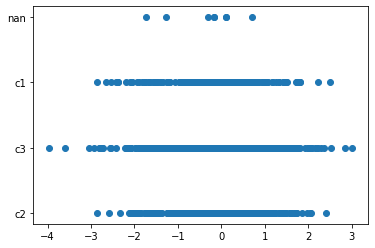

In [76]:
# plot sampled data - normal vs categorical
ax = plt.axes()
ax.scatter(df_samp['x_norm'],df_samp['x_categ'])

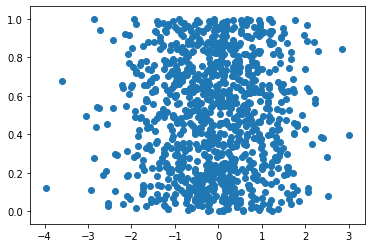

In [77]:
# plot sampled data - normal vs uniform
ax = plt.axes()
ax.scatter(df_samp['x_norm'],df_samp['x_unif'])

# Encoding categorical variables (e.g., for masking the real data)

In [78]:
df_samp.head()

,x_norm,x_unif,x_int,x_categ,x_date
0,2.403762,0.380342,5,c2,2012-11-01
1,-2.740726,0.538691,1,c3,2019-09-03
2,0.125947,0.549280,2,c1,2005-12-29
3,-0.469614,0.941132,4,c2,2008-01-10
4,-0.419283,0.130903,0,c2,2000-06-30


In [79]:
import label_encoder

le_grp_dict = {
    'categ': [df_samp['x_categ']]
}

le_dict = {
    'categ': ['x_categ']
}

le = label_encoder.LabelEncoder(le_grp_dict)
df_samp = le.encode(df_samp, le_dict)
df_samp.head()

,x_norm,x_unif,x_int,x_categ,x_date
0,2.403762,0.380342,5,1,2012-11-01
1,-2.740726,0.538691,1,2,2019-09-03
2,0.125947,0.549280,2,0,2005-12-29
3,-0.469614,0.941132,4,1,2008-01-10
4,-0.419283,0.130903,0,1,2000-06-30


In [80]:
# adding prefix to the encoded categories
prefix_dict = {
    'x_categ': 'cat'
}

df_samp = le.add_prefix(df_samp, prefix_dict)

df_samp.head()

,x_norm,x_unif,x_int,x_categ,x_date
0,2.403762,0.380342,5,cat1,2012-11-01
1,-2.740726,0.538691,1,cat2,2019-09-03
2,0.125947,0.549280,2,cat0,2005-12-29
3,-0.469614,0.941132,4,cat1,2008-01-10
4,-0.419283,0.130903,0,cat1,2000-06-30
